In [1]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import csv

In [3]:
#read stock price data from csv (yahoo finance download) alternative yfinance if posible
MSFT = pd.read_csv('MSFT.csv')
MSFT = pd.DataFrame(MSFT)
MSFT.set_index('Date')

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-07,54.312500,56.125000,53.656250,55.718750,34.613724,62013600
2000-01-10,56.718750,56.843750,55.687500,56.125000,34.866089,44963600
2000-01-11,55.750000,57.125000,54.343750,54.687500,33.973087,46743600
2000-01-12,54.250000,54.437500,52.218750,52.906250,32.866531,66532400
2000-01-13,52.187500,54.312500,50.750000,53.906250,33.487747,83144000
...,...,...,...,...,...,...
2023-08-30,328.670013,329.809998,326.450012,328.790009,328.790009,15222100
2023-08-31,329.200012,330.910004,326.779999,327.760010,327.760010,26411000
2023-09-01,331.309998,331.989990,326.779999,328.660004,328.660004,14931200


In [4]:
#colomn showing next day price
MSFT['Tomorrow'] = MSFT['Adj Close'].shift(-1)

In [5]:
#dummy equal to 1 for daily price increase
MSFT['Target'] = (MSFT['Tomorrow'] > MSFT['Adj Close']).astype(int)    

In [6]:
#import RandomForestClasifier  a common machine learning library , more info https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.ensemble import RandomForestClassifier

In [7]:
#define model, more estimators better
model = RandomForestClassifier(n_estimators = 100, min_samples_split = 100, random_state = 1)

#set training and testing data, here last 100 points are for testing rest is for training
train = MSFT.iloc[:-100]
test = MSFT.iloc[-100:]

#chose the predictors, base this on theory, like when creating a regression model
predictors = {'Open', 'Close', 'Volume', 'High', 'Low'}
model.fit(train[predictors], train['Target'])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [8]:
#import precision_score to measure accuracy
from sklearn.metrics import precision_score

In [9]:
preds = model.predict(test[predictors])

In [10]:
preds = pd.Series(preds, index = test.index)

In [11]:
precision_score(test['Target'],preds)

0.66

In [12]:
combined =  pd.concat([test['Target'],preds], axis = 1 )

<AxesSubplot:>

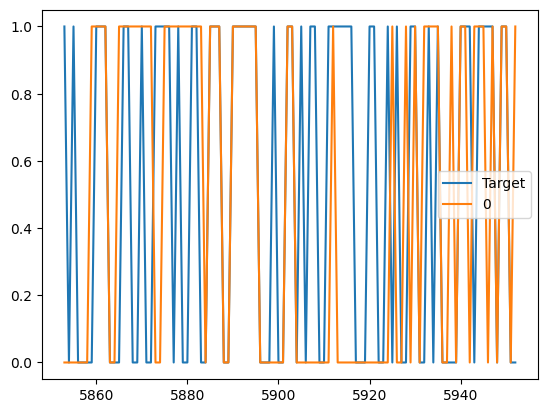

In [13]:
combined.plot()

In [14]:
#group it all under a function for future simplicity
def predict(train, test, predictors, model):
    model.fit(train[predictors],train['Target'])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index = test.index, name = 'Predictions')
    combined =  pd.concat([test['Target'],preds], axis = 1 )
    return combined

In [15]:
#define a function to backtest the model in different periods
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []
    
    for i in range(start,data.shape[0], step):
        train = data.iloc[0:i]
        test = data.iloc[i:i+step]
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [16]:
predictions = backtest(MSFT, model, predictors)

In [17]:
predictions['Predictions'].value_counts()

0    2005
1    1448
Name: Predictions, dtype: int64

In [18]:
precision_score(predictions['Target'], predictions['Predictions'])

0.518646408839779

Adding predictors to the model to improve information and hopefully accuaracy

In [19]:
#use iterative to create rolling average and trend columns to add as predictors
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = MSFT.rolling(horizon).mean()
    
    ratio_column = f'Close_Ratio_{horizon}'
    MSFT[ratio_column] = MSFT['Adj Close']/rolling_averages['Adj Close']
    
    trend_column = f'Trend_{horizon}'
    MSFT[trend_column] = MSFT.shift(1).rolling(horizon).sum()['Target']
    
    new_predictors += [ratio_column, trend_column]

In [20]:
MSFT =MSFT.dropna()

In [21]:
model = RandomForestClassifier(n_estimators = 200, min_samples_split = 50, random_state = 1)

In [22]:
#modify predict function to adjust the probability threshhold of a positive outcome
def predict(train, test, predictors, model):
    model.fit(train[predictors],train['Target'])
    preds = model.predict_proba(test[predictors])[:,1] #second column adds probability
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index = test.index, name = 'Predictions')
    combined =  pd.concat([test['Target'],preds], axis = 1 )
    return combined

In [23]:
predictions = backtest(MSFT, model, new_predictors)

In [24]:
predictions['Predictions'].value_counts()

0.0    2310
1.0     142
Name: Predictions, dtype: int64

In [25]:
precision_score(predictions['Target'], predictions['Predictions'])

0.5704225352112676